# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="images/encoder_decoder.png" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Import stuff

In [2]:
import sys
sys.path.append("..")
# import grading
import download_utils

In [3]:
download_utils.link_all_keras_resources()

In [6]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
# import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [7]:
# grader = grading.Grader(assignment_key="NEDBg6CgEee8nQ6uE8a7OA", 
#                         all_parts=["19Wpv", "uJh73", "yiJkt", "rbpnH", "E2OIL", "YJR7z"])

In [8]:
# token expires every 30 min
COURSERA_TOKEN = ''
COURSERA_EMAIL = ''

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [9]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="images/inceptionv3.png" style="width:70%">

In [10]:
IMG_SIZE = 299

In [11]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [12]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [13]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['train2014_sample.zip', 'val2014_sample.zip']

# Extract captions for images

In [14]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


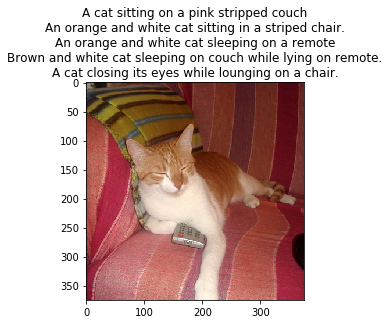

In [15]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [16]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [17]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
#     vocab = ### YOUR CODE HERE ###
    
    sentences = [sentence for caption in train_captions for sentence in caption]
    words = split_sentence(' '.join(sentences))
    
    from collections import Counter
    tokens = Counter(words)
    
    vocab = [token for token, times in tokens.items() if int(times)>=5]
    vocab += [PAD, UNK, START, END]
    
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = [[[vocab[START]] + [vocab[token] if token in vocab else vocab[UNK] for token in split_sentence(sentence)] + [vocab[END]] for sentence in caption] for caption in captions]
    return res

In [18]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [19]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [20]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if not max_len:
        max_len = len(max(batch_captions, key=lambda x: len(x)))
    else:
        max_len = min(max_len, len(max(batch_captions, key=lambda x: len(x))))
    
    matrix = [[index for i, index in enumerate(caption[:max_len])] + [pad_idx]*(max(max_len-len(caption),0)) for caption in batch_captions]
    return np.array(matrix)

In [17]:
## GRADED PART, DO NOT CHANGE!
# Vocabulary creation
# grader.set_answer("19Wpv", grading_utils.test_vocab(vocab, PAD, UNK, START, END))
# # Captions indexing
# grader.set_answer("uJh73", grading_utils.test_captions_indexing(train_captions_indexed, vocab, UNK))
# # Captions batching
# grader.set_answer("yiJkt", grading_utils.test_captions_batching(batch_captions_to_matrix))

In [18]:
# you can make submission with answers so far to check yourself at this stage
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [21]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="images/encoder_decoder_explained.png" style="width:50%">

In [22]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [23]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="images/flatten_help.jpg" style="width:80%">

In [24]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:],[-1,])

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [29]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

C:\Users\StrikeWade\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
## GRADED PART, DO NOT CHANGE!
# Decoder shapes test
# grader.set_answer("rbpnH", grading_utils.test_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s))
# Decoder random loss test
# grader.set_answer("E2OIL", grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

In [25]:
# you can make submission with answers so far to check yourself at this stage
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [25]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [26]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    indx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace=False)
    batch_image_embeddings = images_embeddings[indx_batch]
    
    batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[indx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [27]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [30]:
# you can load trained weights here
# you can load "weights_{epoch}" and continue training
# uncomment the next line if you need to load weights
saver.restore(s, os.path.abspath("weights"))

INFO:tensorflow:Restoring parameters from C:\Users\StrikeWade\Desktop\DLML\Machine-Learning-Courses\Coursera_Advanced_MachineLearning\1_Introduction_to_Deep_Learning\W6 - Image Captioning\weights


Look at the training and validation loss, they should be decreasing!

In [31]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")


Epoch: 0, train loss: 4.332045734405518, val loss: 3.725001094341278

Epoch: 1, train loss: 3.3776412613391877, val loss: 3.1550085043907163

Epoch: 2, train loss: 3.051512755870819, val loss: 2.9935023593902588

Epoch: 3, train loss: 2.89404949259758, val loss: 2.9019125175476073

Epoch: 4, train loss: 2.8039814376831056, val loss: 2.8330394864082336

Epoch: 5, train loss: 2.741228654384613, val loss: 2.766002025604248

Epoch: 6, train loss: 2.68269229054451, val loss: 2.733774034976959

Epoch: 7, train loss: 2.6393487739562986, val loss: 2.7032331442832946

Epoch: 8, train loss: 2.607539389848709, val loss: 2.6588297080993653

Epoch: 9, train loss: 2.5710442812442778, val loss: 2.656646945476532

Epoch: 10, train loss: 2.5448299775123595, val loss: 2.6335193037986757

Epoch: 11, train loss: 2.523213801622391, val loss: 2.6239696860313417
Finished!


In [28]:
## GRADED PART, DO NOT CHANGE!
# Validation loss
# grader.set_answer("YJR7z", grading_utils.test_validation_loss(
#     decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

In [34]:
# you can make submission with answers so far to check yourself at this stage
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [31]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.33538
Accuracy: 0.499300699301
Example 0
Predicted: a bathroom with a sink and and a towels #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a bathroom with large brown tiles and white fixtures #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a woman holding holding a video of a remote wheel #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a woman is playing a game with a steering wheel #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man doing doing in doing a skateboard #END# a park #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a skateboarder is sideways while riding their skateboard in a cement pool #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [36]:
# save graph weights to file!
saver.save(s, os.path.abspath("weights"))

'/home/jovyan/work/week6/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [32]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from C:\Users\StrikeWade\Desktop\DLML\Machine-Learning-Courses\Coursera_Advanced_MachineLearning\1_Introduction_to_Deep_Learning\W6 - Image Captioning\weights


In [33]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [34]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player swinging a bat at a baseball game


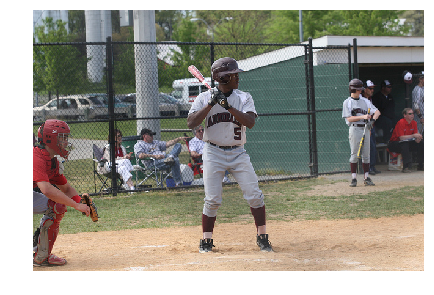

In [35]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a man holding a cell phone in a room


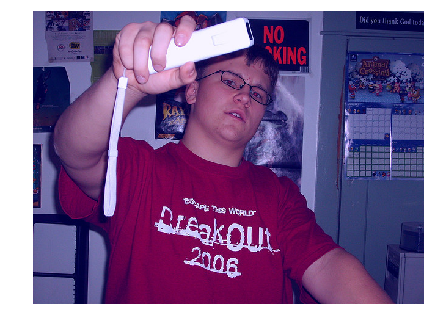

a sheep standing next to a fence with a sheep


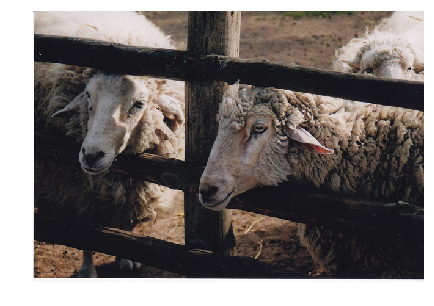

a street sign with a street sign and a street sign


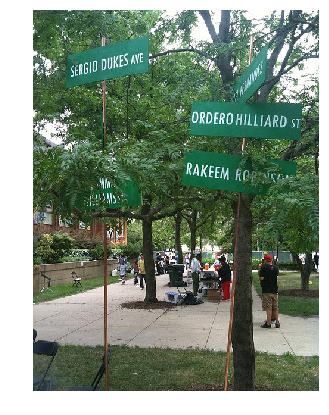

a bowl of fruit and a bowl of fruit


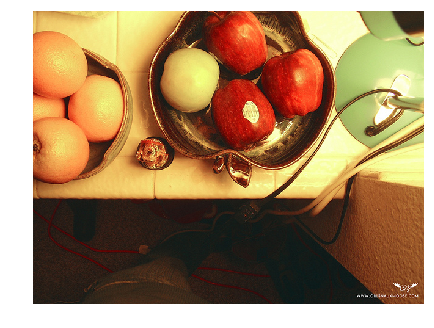

a group of men standing next to each other


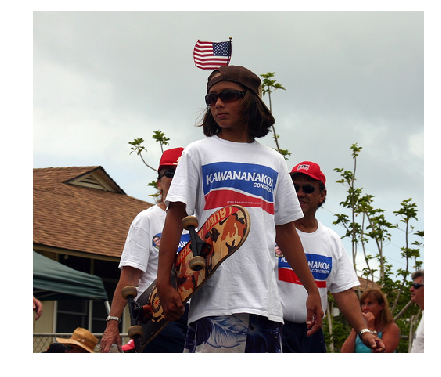

a kitchen with a sink and a microwave


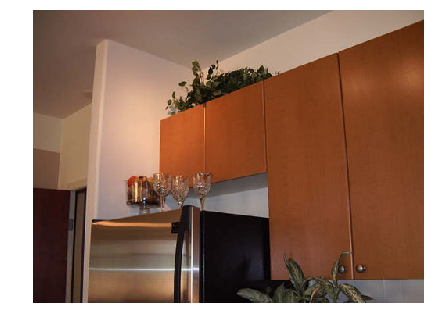

a double decker bus driving down a street


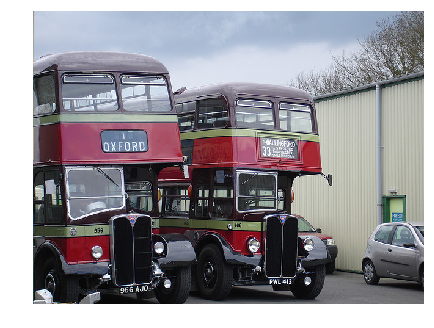

a living room with a couch and a television


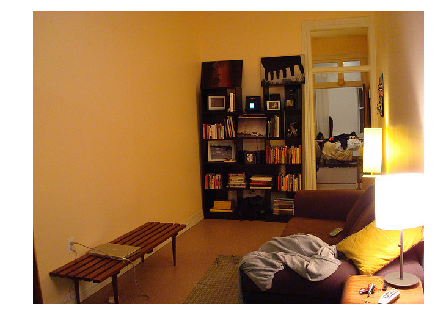

a bicycle parked on a sidewalk next to a building


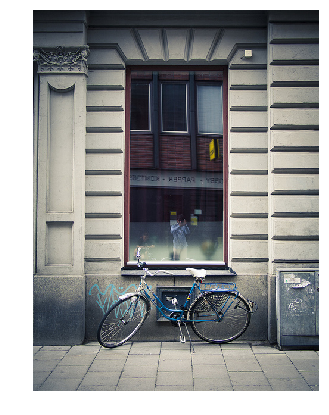

a tennis player is hitting the ball during the game


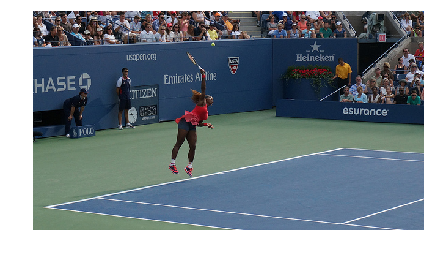

In [34]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [35]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

a cake with a fork and a fork


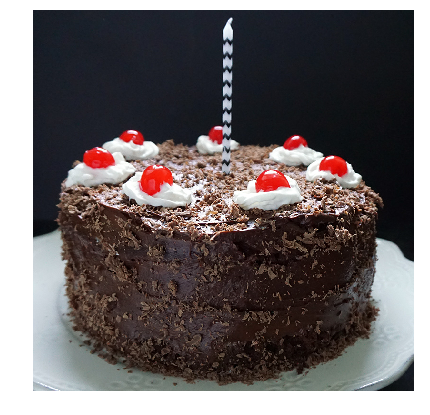

In [36]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

## Good examples with trained model

--2018-10-16 10:34:22--  https://statics.sportskeeda.com/editor/2018/03/c9fc4-1521549182-800.jpg
Resolving statics.sportskeeda.com (statics.sportskeeda.com)... 54.230.192.132, 54.230.192.214, 54.230.192.5, ...
Connecting to statics.sportskeeda.com (statics.sportskeeda.com)|54.230.192.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45720 (45K) [image/jpeg]
Saving to: ‘c9fc4-1521549182-800.jpg’

c9fc4-1521549182-80 100%[=====================>]  44.65K  98.5KB/s   in 0.5s   

2018-10-16 10:34:24 (98.5 KB/s) - ‘c9fc4-1521549182-800.jpg’ saved [45720/45720]

a man in a red shirt playing soccer on a field


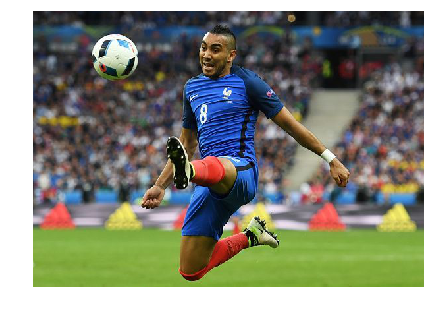

In [39]:
### YOUR EXAMPLES HERE ###
! wget https://statics.sportskeeda.com/editor/2018/03/c9fc4-1521549182-800.jpg
apply_model_to_image_raw_bytes(open("c9fc4-1521549182-800.jpg", "rb").read())

--2018-10-16 10:35:35--  https://i.dailymail.co.uk/i/pix/2015/06/10/13/29815E0C00000578-3115752-image-a-66_1433937693010.jpg
Resolving i.dailymail.co.uk (i.dailymail.co.uk)... 23.13.154.169
Connecting to i.dailymail.co.uk (i.dailymail.co.uk)|23.13.154.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37012 (36K) [image/jpeg]
Saving to: ‘29815E0C00000578-3115752-image-a-66_1433937693010.jpg’

29815E0C00000578-31 100%[=====================>]  36.14K  --.-KB/s   in 0s     

2018-10-16 10:35:35 (195 MB/s) - ‘29815E0C00000578-3115752-image-a-66_1433937693010.jpg’ saved [37012/37012]

a plane is flying in the air with a plane in the background


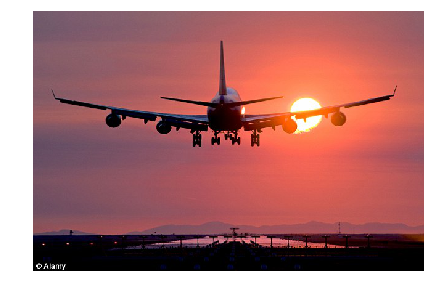

In [40]:
! wget https://i.dailymail.co.uk/i/pix/2015/06/10/13/29815E0C00000578-3115752-image-a-66_1433937693010.jpg
apply_model_to_image_raw_bytes(open("29815E0C00000578-3115752-image-a-66_1433937693010.jpg", "rb").read())

--2018-10-16 10:38:16--  https://cdn1.medicalnewstoday.com/content/images/articles/320/320404/people-celebrating-with-wine-glasses.jpg
Resolving cdn1.medicalnewstoday.com (cdn1.medicalnewstoday.com)... 68.70.205.2, 68.70.205.3, 68.70.205.4, ...
Connecting to cdn1.medicalnewstoday.com (cdn1.medicalnewstoday.com)|68.70.205.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109031 (106K) [image/jpeg]
Saving to: ‘people-celebrating-with-wine-glasses.jpg’

people-celebrating- 100%[=====================>] 106.48K   694KB/s   in 0.2s   

2018-10-16 10:38:16 (694 KB/s) - ‘people-celebrating-with-wine-glasses.jpg’ saved [109031/109031]

a woman pouring wine glasses and wine glasses


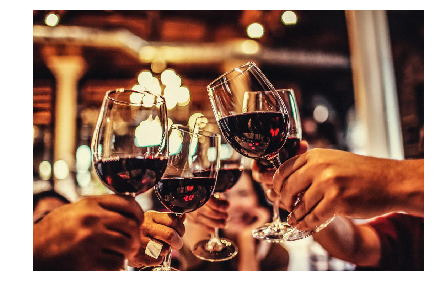

In [41]:
! wget https://cdn1.medicalnewstoday.com/content/images/articles/320/320404/people-celebrating-with-wine-glasses.jpg
apply_model_to_image_raw_bytes(open("people-celebrating-with-wine-glasses.jpg", "rb").read())

--2018-10-16 10:41:45--  https://public-media.smithsonianmag.com/filer/ad/4b/ad4be279-14e2-4c57-af26-a9b8305d8ec2/panda_baby.jpeg
Resolving public-media.smithsonianmag.com (public-media.smithsonianmag.com)... 54.230.192.245, 54.230.192.116, 54.230.192.190, ...
Connecting to public-media.smithsonianmag.com (public-media.smithsonianmag.com)|54.230.192.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 454882 (444K) [image/jpeg]
Saving to: ‘panda_baby.jpeg’

panda_baby.jpeg     100%[=====================>] 444.22K  --.-KB/s   in 0.007s 

2018-10-16 10:41:45 (63.9 MB/s) - ‘panda_baby.jpeg’ saved [454882/454882]

a panda bear is standing in the grass


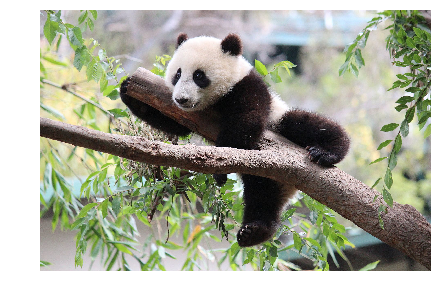

In [42]:
! wget https://public-media.smithsonianmag.com/filer/ad/4b/ad4be279-14e2-4c57-af26-a9b8305d8ec2/panda_baby.jpeg
apply_model_to_image_raw_bytes(open("panda_baby.jpeg", "rb").read())

--2018-10-16 10:42:19--  https://www.disruptsports.com/wp-content/uploads/2016/01/688415-south-west-monster-surf.jpg
Resolving www.disruptsports.com (www.disruptsports.com)... 104.28.12.134, 104.28.13.134, 2606:4700:30::681c:d86, ...
Connecting to www.disruptsports.com (www.disruptsports.com)|104.28.12.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35334 (35K) [image/jpeg]
Saving to: ‘688415-south-west-monster-surf.jpg’

688415-south-west-m 100%[=====================>]  34.51K  --.-KB/s   in 0s     

2018-10-16 10:42:19 (104 MB/s) - ‘688415-south-west-monster-surf.jpg’ saved [35334/35334]

a person riding a wave on a surfboard


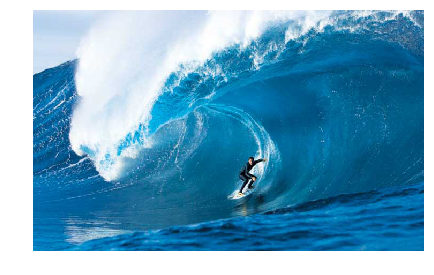

In [43]:
! wget https://www.disruptsports.com/wp-content/uploads/2016/01/688415-south-west-monster-surf.jpg
apply_model_to_image_raw_bytes(open("688415-south-west-monster-surf.jpg", "rb").read())

--2018-10-13 00:00:25--  https://kenh14cdn.com/2017/img-0263-1462201623371-1-1509159587195.jpg
Resolving kenh14cdn.com (kenh14cdn.com)... 222.255.27.45, 222.255.27.184, 222.255.27.187, ...
Connecting to kenh14cdn.com (kenh14cdn.com)|222.255.27.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 781260 (763K) [image/jpeg]
Saving to: ‘xuanthao.jpg’

xuanthao.jpg        100%[=====================>] 762.95K   563KB/s   in 1.4s   

2018-10-13 00:00:28 (563 KB/s) - ‘xuanthao.jpg’ saved [781260/781260]

a woman holding a cell phone while holding a cell phone


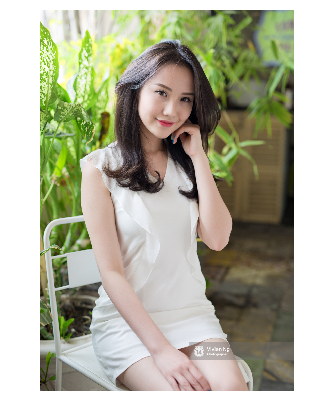

In [47]:
! wget -O xuanthao.jpg https://kenh14cdn.com/2017/img-0263-1462201623371-1-1509159587195.jpg
apply_model_to_image_raw_bytes(open("xuanthao.jpg", "rb").read())

--2018-10-16 10:45:41--  https://images.pexels.com/photos/48794/boy-walking-teddy-bear-child-48794.jpeg
Resolving images.pexels.com (images.pexels.com)... 104.16.239.112, 104.16.240.112, 104.16.241.112, ...
Connecting to images.pexels.com (images.pexels.com)|104.16.239.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322663 (1.3M) [image/jpeg]
Saving to: ‘boy-walking-teddy-bear-child-48794.jpeg.1’

boy-walking-teddy-b 100%[=====================>]   1.26M  --.-KB/s   in 0.01s  

2018-10-16 10:45:41 (111 MB/s) - ‘boy-walking-teddy-bear-child-48794.jpeg.1’ saved [1322663/1322663]

a small child sitting on a bench next to a teddy bear


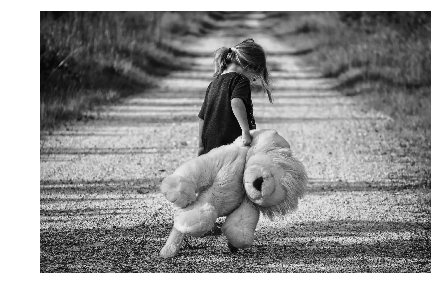

In [45]:
! wget https://images.pexels.com/photos/48794/boy-walking-teddy-bear-child-48794.jpeg
apply_model_to_image_raw_bytes(open("boy-walking-teddy-bear-child-48794.jpeg", "rb").read())

--2018-10-16 10:47:02--  https://animals.sandiegozoo.org/sites/default/files/2016-08/category-thumbnail-mammals_0.jpg
Resolving animals.sandiegozoo.org (animals.sandiegozoo.org)... 209.61.166.52
Connecting to animals.sandiegozoo.org (animals.sandiegozoo.org)|209.61.166.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176536 (172K) [image/jpeg]
Saving to: ‘category-thumbnail-mammals_0.jpg’

category-thumbnail- 100%[=====================>] 172.40K   878KB/s   in 0.2s   

2018-10-16 10:47:02 (878 KB/s) - ‘category-thumbnail-mammals_0.jpg’ saved [176536/176536]

a panda bear sitting on top of a wooden bench


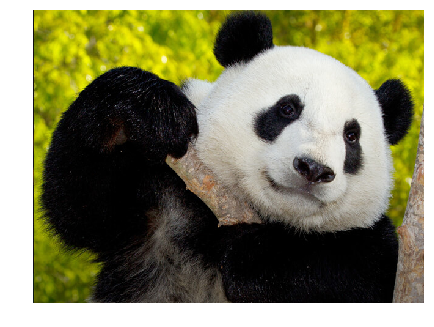

In [46]:
! wget https://animals.sandiegozoo.org/sites/default/files/2016-08/category-thumbnail-mammals_0.jpg
apply_model_to_image_raw_bytes(open("category-thumbnail-mammals_0.jpg", "rb").read())

--2018-10-16 10:50:37--  https://i.ytimg.com/vi/EK1Cv4bL_sI/maxresdefault.jpg
Resolving i.ytimg.com (i.ytimg.com)... 216.58.217.118, 216.58.217.182, 216.58.218.246, ...
Connecting to i.ytimg.com (i.ytimg.com)|216.58.217.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1138895 (1.1M) [image/jpeg]
Saving to: ‘maxresdefault.jpg’

maxresdefault.jpg   100%[=====================>]   1.09M  --.-KB/s   in 0.06s  

2018-10-16 10:50:37 (18.9 MB/s) - ‘maxresdefault.jpg’ saved [1138895/1138895]

a man riding a bike down a hill


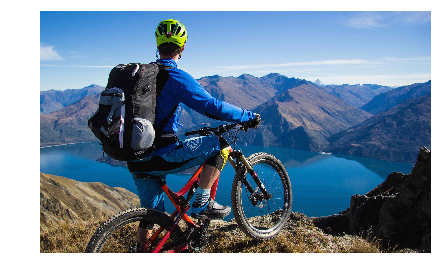

In [51]:
! wget https://i.ytimg.com/vi/EK1Cv4bL_sI/maxresdefault.jpg
apply_model_to_image_raw_bytes(open("maxresdefault.jpg", "rb").read())

--2018-10-16 10:53:38--  https://foreignpolicymag.files.wordpress.com/2018/09/gettyimages-911985014.jpg
Resolving foreignpolicymag.files.wordpress.com (foreignpolicymag.files.wordpress.com)... 192.0.72.19, 192.0.72.18
Connecting to foreignpolicymag.files.wordpress.com (foreignpolicymag.files.wordpress.com)|192.0.72.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 816083 (797K) [image/jpeg]
Saving to: ‘gettyimages-911985014.jpg’

gettyimages-9119850 100%[=====================>] 796.96K  --.-KB/s   in 0.007s 

2018-10-16 10:53:38 (107 MB/s) - ‘gettyimages-911985014.jpg’ saved [816083/816083]

a group of men standing next to each other on a field


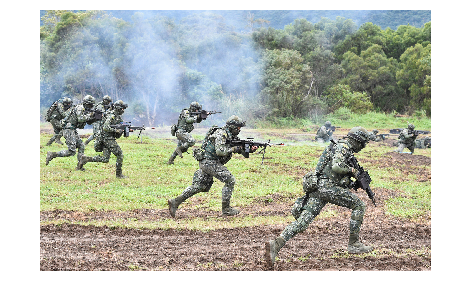

In [56]:
! wget https://foreignpolicymag.files.wordpress.com/2018/09/gettyimages-911985014.jpg
apply_model_to_image_raw_bytes(open("gettyimages-911985014.jpg", "rb").read())

## Bad examples with trained model

--2018-10-13 00:03:25--  https://www.telegraph.co.uk/content/dam/Travel/hotels/europe/france/paris/eiffel-tower-paris-p.jpg
Resolving www.telegraph.co.uk (www.telegraph.co.uk)... 23.13.166.50
Connecting to www.telegraph.co.uk (www.telegraph.co.uk)|23.13.166.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘paris.jpg’

paris.jpg               [ <=>                  ] 768.08K  --.-KB/s   in 0.009s 

Last-modified header invalid -- time-stamp ignored.
2018-10-13 00:03:25 (82.8 MB/s) - ‘paris.jpg’ saved [786509]

a large bird flying over a tree in a field


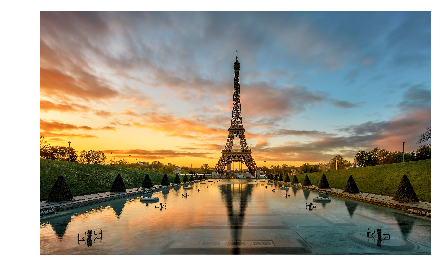

In [49]:
! wget -O paris.jpg https://www.telegraph.co.uk/content/dam/Travel/hotels/europe/france/paris/eiffel-tower-paris-p.jpg
apply_model_to_image_raw_bytes(open("paris.jpg", "rb").read())

--2018-10-16 10:48:10--  https://kids.nationalgeographic.com/content/dam/kids/photos/animals/Mammals/A-G/caracal-run.ngsversion.1435834128807.jpg
Resolving kids.nationalgeographic.com (kids.nationalgeographic.com)... 23.195.64.193
Connecting to kids.nationalgeographic.com (kids.nationalgeographic.com)|23.195.64.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 869139 (849K) [image/jpeg]
Saving to: ‘caracal-run.ngsversion.1435834128807.jpg.1’

caracal-run.ngsvers 100%[=====================>] 848.77K  --.-KB/s   in 0.008s 

2018-10-16 10:48:10 (106 MB/s) - ‘caracal-run.ngsversion.1435834128807.jpg.1’ saved [869139/869139]

a cat is standing in the grass with a frisbee


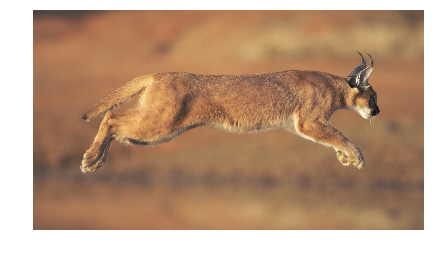

In [48]:
! wget https://kids.nationalgeographic.com/content/dam/kids/photos/animals/Mammals/A-G/caracal-run.ngsversion.1435834128807.jpg
apply_model_to_image_raw_bytes(open("caracal-run.ngsversion.1435834128807.jpg", "rb").read())

--2018-10-16 10:49:38--  http://www.lincoln.ac.nz/Global/images/785x410%20Template%2004/Sport-318528_FA.jpg
Resolving www.lincoln.ac.nz (www.lincoln.ac.nz)... 103.240.53.22
Connecting to www.lincoln.ac.nz (www.lincoln.ac.nz)|103.240.53.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95816 (94K) [image/jpeg]
Saving to: ‘Sport-318528_FA.jpg.1’

Sport-318528_FA.jpg 100%[=====================>]  93.57K  70.0KB/s   in 1.3s   

2018-10-16 10:49:40 (70.0 KB/s) - ‘Sport-318528_FA.jpg.1’ saved [95816/95816]

a man riding a bike down a hill with a dog


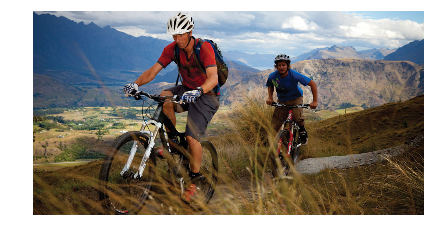

In [50]:
! wget http://www.lincoln.ac.nz/Global/images/785x410%20Template%2004/Sport-318528_FA.jpg
apply_model_to_image_raw_bytes(open("Sport-318528_FA.jpg", "rb").read())

--2018-10-16 10:51:36--  http://www.victorycollege.com.au/wp-content/uploads/img-sport-rugby.jpg
Resolving www.victorycollege.com.au (www.victorycollege.com.au)... 27.121.67.37
Connecting to www.victorycollege.com.au (www.victorycollege.com.au)|27.121.67.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157849 (154K) [image/jpeg]
Saving to: ‘img-sport-rugby.jpg.1’

img-sport-rugby.jpg 100%[=====================>] 154.15K   140KB/s   in 1.1s   

2018-10-16 10:51:37 (140 KB/s) - ‘img-sport-rugby.jpg.1’ saved [157849/157849]

a man in a white shirt playing frisbee in a park


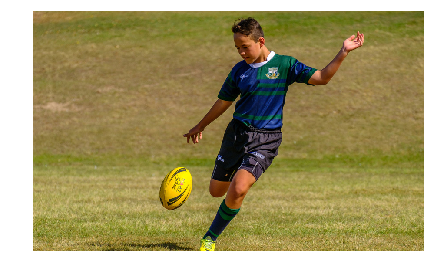

In [53]:
! wget http://www.victorycollege.com.au/wp-content/uploads/img-sport-rugby.jpg
apply_model_to_image_raw_bytes(open("img-sport-rugby.jpg", "rb").read())

--2018-10-16 10:52:38--  https://sport.exeter.ac.uk/media/universityofexeter/campusservices/sport/images930x500/hockey/hockey-dan-jackson-scholor.jpg
Resolving sport.exeter.ac.uk (sport.exeter.ac.uk)... 144.173.6.226
Connecting to sport.exeter.ac.uk (sport.exeter.ac.uk)|144.173.6.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73084 (71K) [image/jpeg]
Saving to: ‘hockey-dan-jackson-scholor.jpg.1’

hockey-dan-jackson- 100%[=====================>]  71.37K   297KB/s   in 0.2s   

2018-10-16 10:52:38 (297 KB/s) - ‘hockey-dan-jackson-scholor.jpg.1’ saved [73084/73084]

a man in a red shirt is playing frisbee


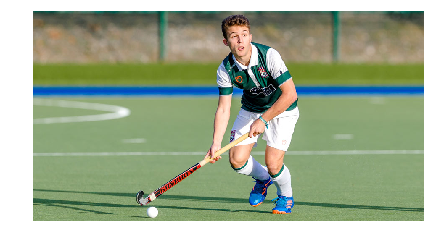

In [55]:
! wget https://sport.exeter.ac.uk/media/universityofexeter/campusservices/sport/images930x500/hockey/hockey-dan-jackson-scholor.jpg
apply_model_to_image_raw_bytes(open("hockey-dan-jackson-scholor.jpg", "rb").read())

--2018-10-16 10:54:50--  https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Midu_-_Summer_2012_%28Explored_1_-_May_24th%29_cropped.jpg/1200px-Midu_-_Summer_2012_%28Explored_1_-_May_24th%29_cropped.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216263 (211K) [image/jpeg]
Saving to: ‘midu.jpg’

midu.jpg            100%[=====================>] 211.19K  --.-KB/s   in 0.007s 

2018-10-16 10:54:50 (30.9 MB/s) - ‘midu.jpg’ saved [216263/216263]

a woman holding a cell phone while holding a cell phone


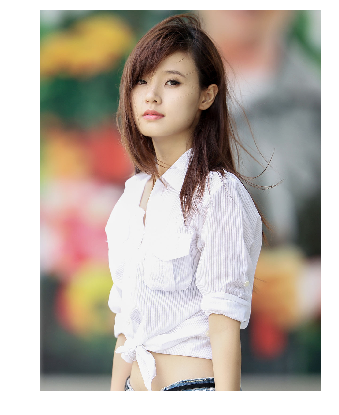

In [57]:
! wget -O midu.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Midu_-_Summer_2012_%28Explored_1_-_May_24th%29_cropped.jpg/1200px-Midu_-_Summer_2012_%28Explored_1_-_May_24th%29_cropped.jpg
apply_model_to_image_raw_bytes(open("midu.jpg", "rb").read())

--2018-10-16 10:55:21--  http://www.bitexcofinancialtower.com/wp-content/themes/responsive/core/images/3.jpg
Resolving www.bitexcofinancialtower.com (www.bitexcofinancialtower.com)... 115.79.47.164
Connecting to www.bitexcofinancialtower.com (www.bitexcofinancialtower.com)|115.79.47.164|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264397 (258K) [image/jpeg]
Saving to: ‘saigon.jpg’

saigon.jpg          100%[=====================>] 258.20K  55.2KB/s   in 4.7s   

2018-10-16 10:55:28 (55.2 KB/s) - ‘saigon.jpg’ saved [264397/264397]

a large crowd of people standing on a beach


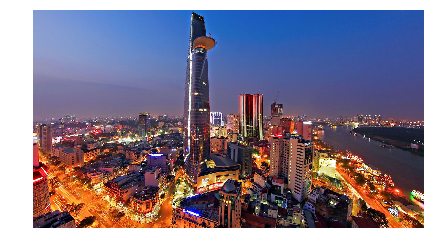

In [59]:
! wget -O saigon.jpg http://www.bitexcofinancialtower.com/wp-content/themes/responsive/core/images/3.jpg
apply_model_to_image_raw_bytes(open("saigon.jpg", "rb").read())

--2018-10-16 10:55:55--  https://www.culturecreature.com/wp-content/uploads/2016/08/nine-inch-nails-woodstock-94-2-650x418.jpg
Resolving www.culturecreature.com (www.culturecreature.com)... 132.148.208.216
Connecting to www.culturecreature.com (www.culturecreature.com)|132.148.208.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55197 (54K) [image/jpeg]
Saving to: ‘nine-inch-nails-woodstock-94-2-650x418.jpg’

nine-inch-nails-woo 100%[=====================>]  53.90K   320KB/s   in 0.2s   

2018-10-16 10:55:56 (320 KB/s) - ‘nine-inch-nails-woodstock-94-2-650x418.jpg’ saved [55197/55197]

a man holding a cell phone while standing on a street


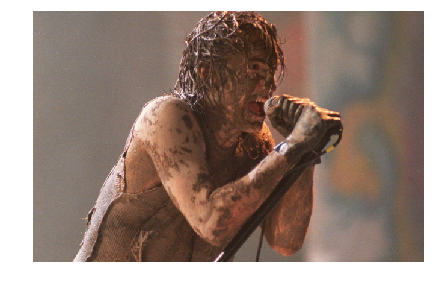

In [60]:
! wget https://www.culturecreature.com/wp-content/uploads/2016/08/nine-inch-nails-woodstock-94-2-650x418.jpg
apply_model_to_image_raw_bytes(open("nine-inch-nails-woodstock-94-2-650x418.jpg", "rb").read())

--2018-10-16 10:56:13--  https://s.abcnews.com/images/US/branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg
Resolving s.abcnews.com (s.abcnews.com)... 104.110.192.75
Connecting to s.abcnews.com (s.abcnews.com)|104.110.192.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77688 (76K) [image/jpeg]
Saving to: ‘branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg’

branch-davidian-fir 100%[=====================>]  75.87K  --.-KB/s   in 0s     

2018-10-16 10:56:13 (232 MB/s) - ‘branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg’ saved [77688/77688]

a train is coming down the tracks near a mountain


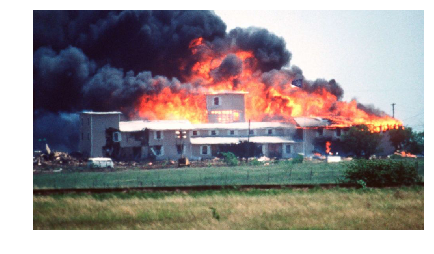

In [61]:
! wget https://s.abcnews.com/images/US/branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg
apply_model_to_image_raw_bytes(open("branch-davidian-fire-01-gty-jc-180103_16x9_992.jpg", "rb").read())

--2018-10-16 10:57:04--  https://www.chathamhouse.org/sites/default/files/styles/main_image_800x460/public/field/field_image_main/Lewis_4.jpg
Resolving www.chathamhouse.org (www.chathamhouse.org)... 54.76.252.179, 52.19.169.209, 52.212.172.163
Connecting to www.chathamhouse.org (www.chathamhouse.org)|54.76.252.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41836 (41K) [image/jpeg]
Saving to: ‘Lewis_4.jpg’

Lewis_4.jpg         100%[=====================>]  40.86K  --.-KB/s   in 0.03s  

2018-10-16 10:57:04 (1.36 MB/s) - ‘Lewis_4.jpg’ saved [41836/41836]

a large plane is on a runway near a building


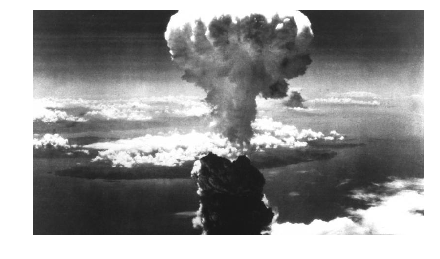

In [63]:
! wget https://www.chathamhouse.org/sites/default/files/styles/main_image_800x460/public/field/field_image_main/Lewis_4.jpg
apply_model_to_image_raw_bytes(open("Lewis_4.jpg", "rb").read())

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!